In [ ]:
import numpy as np
import keras
from keras import layers

original_dim = 28 * 28
intermediate_dim = 64
latent_dim = 10

inputs = keras.Input(shape=(original_dim,))
h = layers.Dense(intermediate_dim, activation='relu')(inputs)
z_mean = layers.Dense(latent_dim)(h)

z_log_sigma = layers.Dense(latent_dim)(h)
print(z_mean.shape)

(None, 10)


In [ ]:
from keras import backend as K

def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon

In [ ]:
z = layers.Lambda(sampling)([z_mean, z_log_sigma])

In [ ]:
# Create encoder
encoder = keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

# Create decoder
latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = layers.Dense(original_dim, activation='sigmoid')(x)

decoder = keras.Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = keras.Model(inputs, outputs, name='vae_mlp')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 784)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 64)           50240       ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 10)           650         ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 10)           650         ['dense[0][0]']                  
                                                                                            

In [ ]:
reconstruction_loss = keras.losses.binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)



vae.compile(optimizer='adam')

In [ ]:

from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

vae.fit(x_train, x_train,
        epochs=20,
        batch_size=32)
        #validation_data=(x_test, x_test))

x_decoded = vae.predict(x_train)


11501568/11490434 [==============================] - 0s 0us/step
Epoch 1/20
1875/1875 [==============================] - 7s 3ms/step - loss: 146.9814
Epoch 2/20
1875/1875 [==============================] - 5s 2ms/step - loss: 116.5320
Epoch 3/20
1875/1875 [==============================] - 5s 3ms/step - loss: 110.3126
Epoch 4/20
1875/1875 [==============================] - 5s 2ms/step - loss: 106.8801
Epoch 5/20
1875/1875 [==============================] - 5s 3ms/step - loss: 104.8295
Epoch 6/20
1875/1875 [==============================] - 5s 3ms/step - loss: 103.5462
Epoch 7/20
1875/1875 [==============================] - 5s 3ms/step - loss: 102.6076
Epoch 8/20
1875/1875 [==============================] - 5s 3ms/step - loss: 101.8936
Epoch 9/20
1875/1875 [==============================] - 5s 2ms/step - loss: 101.2994
Epoch 10/20
1875/1875 [==============================] - 5s 3ms/step - loss: 100.8048
Epoch 11/20
1875/1875 [==============================] - 5s 2ms/step - loss: 100.376

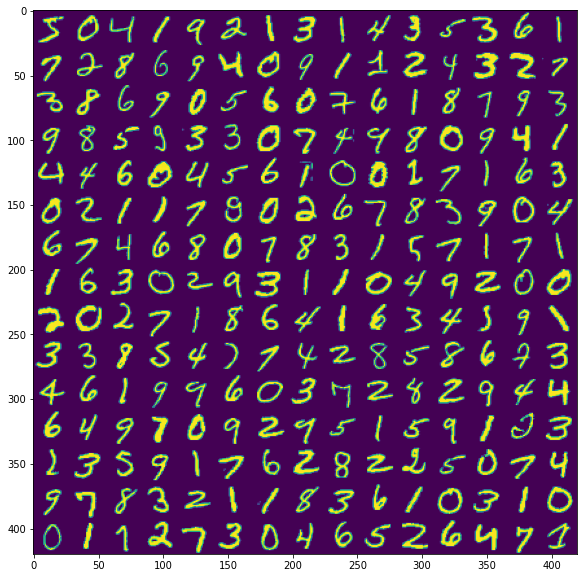

In [ ]:
import matplotlib.pyplot as plt
# Display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# We will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)
k=0
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        #x_decoded = decoder.predict(z_sample)
        digit = x_train[k].reshape(digit_size, digit_size)
        k = k +1
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()


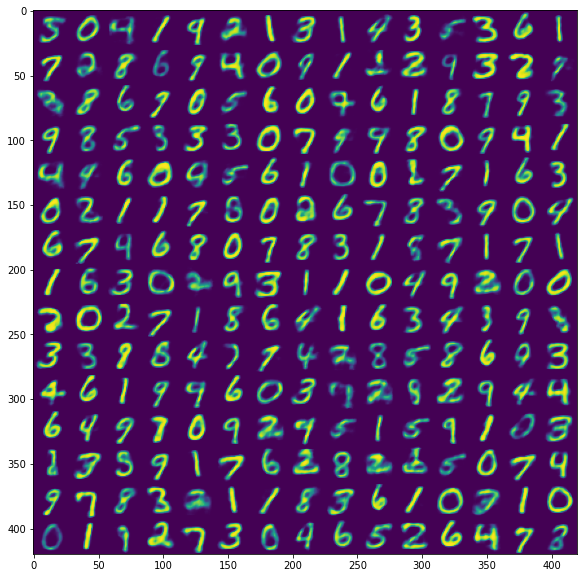

In [ ]:
# Display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# We will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)
k=0
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        #x_decoded = decoder.predict(z_sample)
        digit = x_decoded[k].reshape(digit_size, digit_size)
        k = k +1
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()

In [ ]:

z_zz = encoder.predict(x_train)
print (z_zz[2].shape)
print (z_zz[2][0].shape)

#x_decoded = decoder.predict(z_zz[2]+0.01)
x_decoded = decoder.predict(z_zz[0]+z_zz[1] * 0.4)

(60000, 10)
(10,)


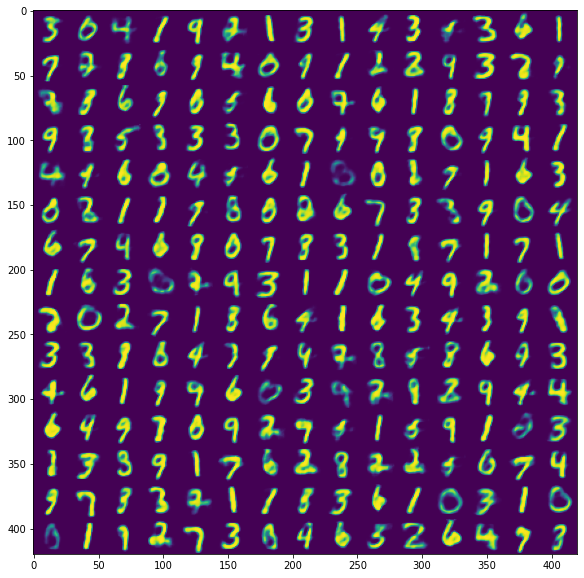

In [ ]:
# Display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# We will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)
k=0
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        #z_sample = np.array([[xi, yi]])
        #x_decoded = decoder.predict(z_sample)
        
        digit = x_decoded[k].reshape(digit_size, digit_size)
        k=k+1
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()


In [ ]:
z_zz[2].shape

(60000, 10)

# Method 1

In [ ]:
y_train[0]

5

In [ ]:
from math import inf
z_zz = encoder.predict(x_train)
dist = 0, min_dist = inf
min_img = []

target = x_train[0] 
for i in range(0.01, 0.9, 0.01):
  x_decoded = decoder.predict(z_zz[0]+z_zz[1] * i)
  square = np.square(x_decoded - target)
  dist = np.sum(square)
  if dist < min_dist:
    dist = min_dist
    min_img = x_decoded

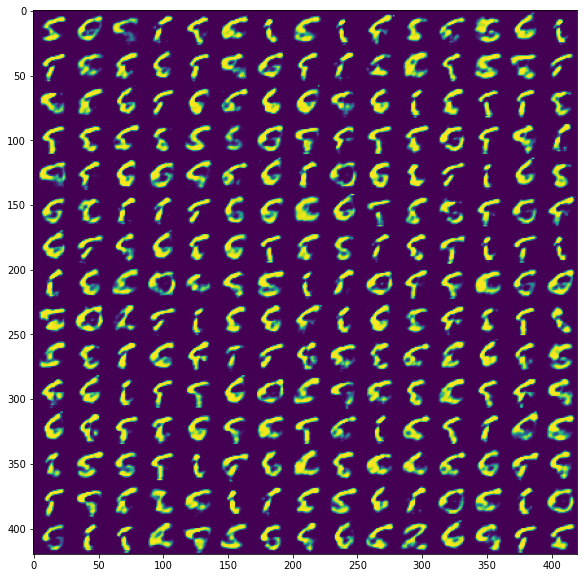

In [ ]:
z_zz = encoder.predict(x_train)
print (z_zz[2].shape)
print (z_zz[2][0].shape)

x_decoded = decoder.predict(z_zz[2]+0.9)
#x_decoded = decoder.predict(z_zz[0]+z_zz[1] * 0.4)

# Display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# We will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)
k=0
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        #z_sample = np.array([[xi, yi]])
        #x_decoded = decoder.predict(z_sample)
        
        digit = x_decoded[k].reshape(digit_size, digit_size)
        k=k+1
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()


In [ ]:

x_decoded = decoder.predict(z_zz[2]+0.5)

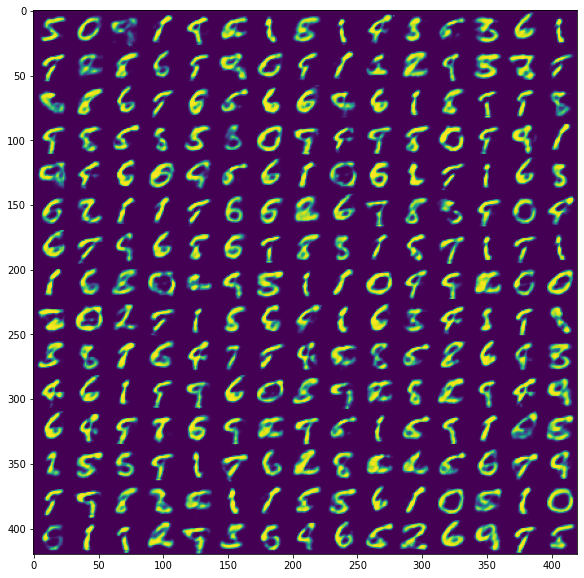

In [ ]:
# Display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# We will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)
k=0
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        #z_sample = np.array([[xi, yi]])
        #x_decoded = decoder.predict(z_sample)
        
        digit = x_decoded[k].reshape(digit_size, digit_size)
        k=k+1
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()


In [ ]:
x_decoded = decoder.predict(z_zz[2]+0.05)

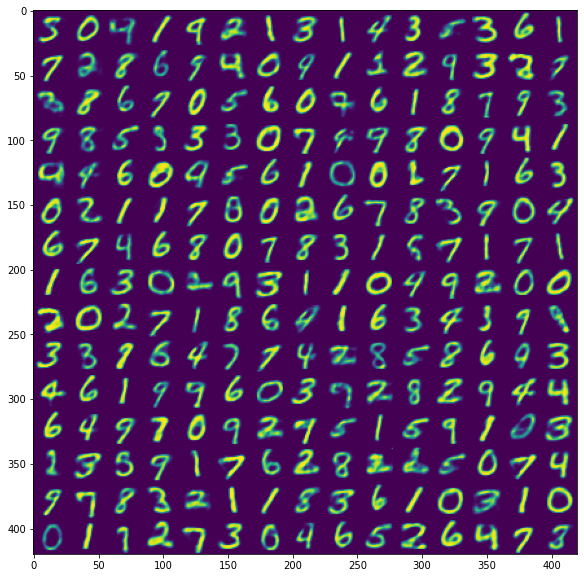

In [ ]:
# Display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# We will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)
k=0
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        #z_sample = np.array([[xi, yi]])
        #x_decoded = decoder.predict(z_sample)
        
        digit = x_decoded[k].reshape(digit_size, digit_size)
        k=k+1
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()

# Method 2

In [ ]:
x_decoded = decoder.predict(z_zz[0]+z_zz[1] * 0.9)

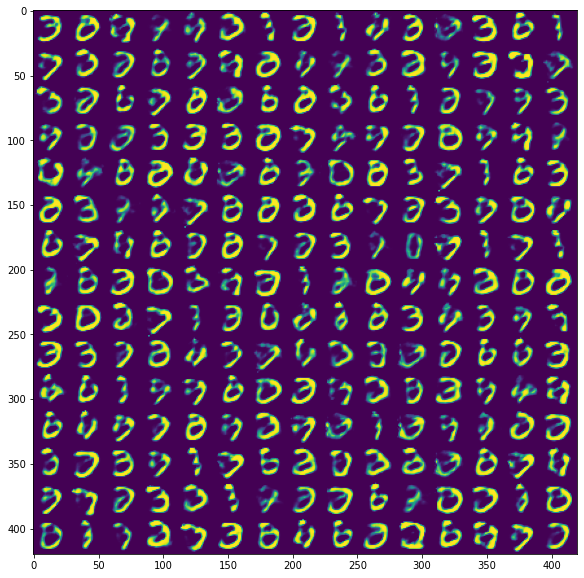

In [ ]:
# Display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# We will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)
k=0
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        #z_sample = np.array([[xi, yi]])
        #x_decoded = decoder.predict(z_sample)
        
        digit = x_decoded[k].reshape(digit_size, digit_size)
        k=k+1
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()

In [ ]:
x_decoded = decoder.predict(z_zz[0]+z_zz[1] * 0.5)

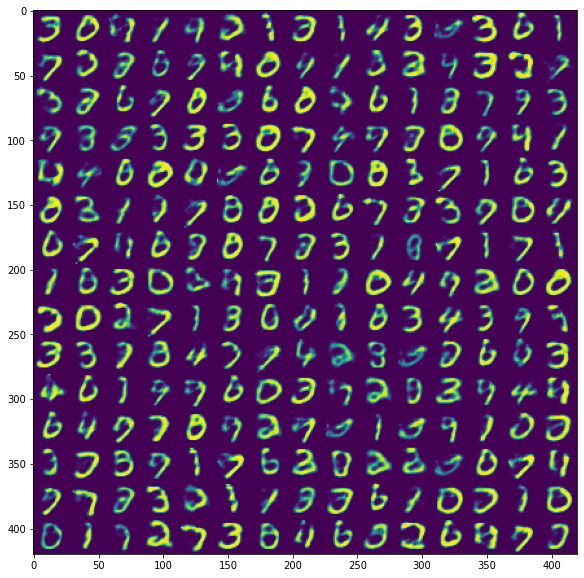

In [ ]:
# Display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# We will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)
k=0
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        #z_sample = np.array([[xi, yi]])
        #x_decoded = decoder.predict(z_sample)
        
        digit = x_decoded[k].reshape(digit_size, digit_size)
        k=k+1
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()

In [ ]:
x_decoded = decoder.predict(z_zz[0]+z_zz[1] * 0.05)

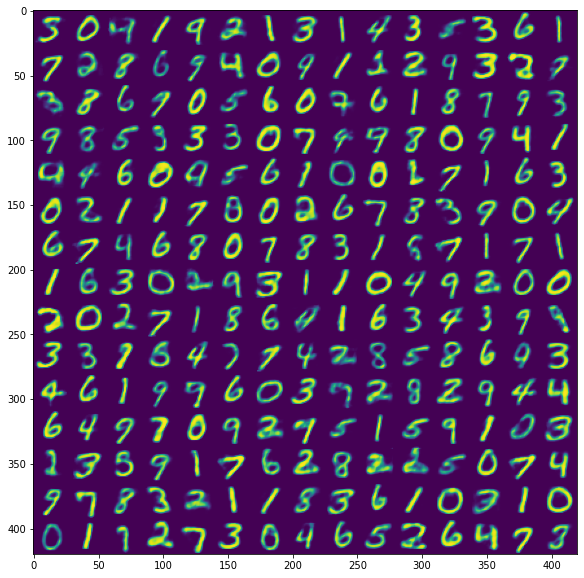

In [ ]:
# Display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# We will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)
k=0
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        #z_sample = np.array([[xi, yi]])
        #x_decoded = decoder.predict(z_sample)
        
        digit = x_decoded[k].reshape(digit_size, digit_size)
        k=k+1
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()

# Deeper model

In [ ]:
import keras
from keras import layers
import numpy as np

original_dim = 28 * 28
intermediate_dim = 64
extra_dim1 = 32
extra_dim2 = 16
latent_dim = 10

inputs = keras.Input(shape=(original_dim,))
h = layers.Dense(intermediate_dim, activation='relu')(inputs)
h = layers.Dense(extra_dim1, activation='relu')(h)
h = layers.Dense(extra_dim2, activation='relu')(h)
z_mean = layers.Dense(latent_dim)(h)

z_log_sigma = layers.Dense(latent_dim)(h)
print(z_mean.shape)

(None, 10)


In [ ]:
from keras import backend as K

def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon

In [ ]:

z = layers.Lambda(sampling)([z_mean, z_log_sigma])


In [ ]:
# Create encoder
encoder = keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

# Create decoder
latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(extra_dim2, activation='relu')(latent_inputs)
x = layers.Dense(extra_dim1, activation='relu')(x)
x = layers.Dense(intermediate_dim, activation='relu')(x)


outputs = layers.Dense(original_dim, activation='sigmoid')(x)

decoder = keras.Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = keras.Model(inputs, outputs, name='vae_mlp')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 784)]        0           []                               
                                                                                                  
 dense_5 (Dense)                (None, 64)           50240       ['input_2[0][0]']                
                                                                                                  
 dense_6 (Dense)                (None, 32)           2080        ['dense_5[0][0]']                
                                                                                                  
 dense_7 (Dense)                (None, 16)           528         ['dense_6[0][0]']                
                                                                                            

In [ ]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 10)]              0         
                                                                 
 dense_10 (Dense)            (None, 16)                176       
                                                                 
 dense_11 (Dense)            (None, 32)                544       
                                                                 
 dense_12 (Dense)            (None, 64)                2112      
                                                                 
 dense_13 (Dense)            (None, 784)               50960     
                                                                 
Total params: 53,792
Trainable params: 53,792
Non-trainable params: 0
_________________________________________________________________


In [ ]:
reconstruction_loss = keras.losses.binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)



vae.compile(optimizer='adam')

In [ ]:

from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

vae.fit(x_train, x_train,
        epochs=100,
        batch_size=32)
        #validation_data=(x_test, x_test))

x_decoded = vae.predict(x_train)


Epoch 1/100
1875/1875 [==============================] - 10s 5ms/step - loss: 170.4805
Epoch 2/100
1875/1875 [==============================] - 9s 5ms/step - loss: 129.4128
Epoch 3/100
1875/1875 [==============================] - 9s 5ms/step - loss: 120.9885
Epoch 4/100
1875/1875 [==============================] - 9s 5ms/step - loss: 117.1405
Epoch 5/100
1875/1875 [==============================] - 9s 5ms/step - loss: 114.1046
Epoch 6/100
1875/1875 [==============================] - 9s 5ms/step - loss: 111.7949
Epoch 7/100
1875/1875 [==============================] - 9s 5ms/step - loss: 110.3482
Epoch 8/100
1875/1875 [==============================] - 9s 5ms/step - loss: 109.2105
Epoch 9/100
1875/1875 [==============================] - 9s 5ms/step - loss: 108.2692
Epoch 10/100
1875/1875 [==============================] - 9s 5ms/step - loss: 107.4063
Epoch 11/100
1875/1875 [==============================] - 9s 5ms/step - loss: 106.4586
Epoch 12/100
1875/1875 [===========================

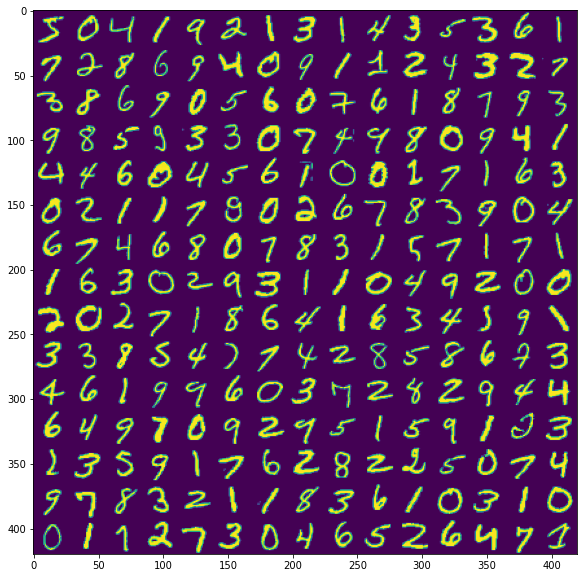

In [ ]:
# Display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# We will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)
k=0
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        #x_decoded = decoder.predict(z_sample)
        digit = x_train[k].reshape(digit_size, digit_size)
        k = k +1
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()


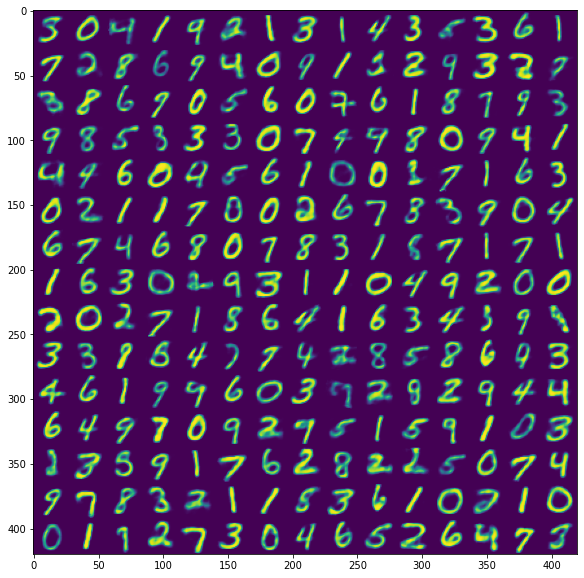

In [ ]:
# Display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# We will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)
k=0
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        #x_decoded = decoder.predict(z_sample)
        digit = x_decoded[k].reshape(digit_size, digit_size)
        k = k +1
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()



# Different latent dimensions

In [ ]:
import keras
from keras import layers
import numpy as np

original_dim = 28 * 28
intermediate_dim = 64
extra_dim1 = 32
extra_dim2 = 16
latent_dim = 5

inputs = keras.Input(shape=(original_dim,))
h = layers.Dense(intermediate_dim, activation='relu')(inputs)
h = layers.Dense(extra_dim1, activation='relu')(h)
h = layers.Dense(extra_dim2, activation='relu')(h)
z_mean = layers.Dense(latent_dim)(h)

z_log_sigma = layers.Dense(latent_dim)(h)
print(z_mean.shape)

(None, 5)


In [ ]:

z = layers.Lambda(sampling)([z_mean, z_log_sigma])


In [ ]:
# Create encoder
encoder = keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

# Create decoder
latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(extra_dim2, activation='relu')(latent_inputs)
x = layers.Dense(extra_dim1, activation='relu')(x)
x = layers.Dense(intermediate_dim, activation='relu')(x)


outputs = layers.Dense(original_dim, activation='sigmoid')(x)

decoder = keras.Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = keras.Model(inputs, outputs, name='vae_mlp')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 784)]        0           []                               
                                                                                                  
 dense_14 (Dense)               (None, 64)           50240       ['input_3[0][0]']                
                                                                                                  
 dense_15 (Dense)               (None, 32)           2080        ['dense_14[0][0]']               
                                                                                                  
 dense_16 (Dense)               (None, 16)           528         ['dense_15[0][0]']               
                                                                                            

In [ ]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 5)]               0         
                                                                 
 dense_19 (Dense)            (None, 16)                96        
                                                                 
 dense_20 (Dense)            (None, 32)                544       
                                                                 
 dense_21 (Dense)            (None, 64)                2112      
                                                                 
 dense_22 (Dense)            (None, 784)               50960     
                                                                 
Total params: 53,712
Trainable params: 53,712
Non-trainable params: 0
_________________________________________________________________


In [ ]:
reconstruction_loss = keras.losses.binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)



vae.compile(optimizer='adam')

In [ ]:

from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

vae.fit(x_train, x_train,
        epochs=100,
        batch_size=32)
        #validation_data=(x_test, x_test))

x_decoded = vae.predict(x_train)


Epoch 1/100
1875/1875 [==============================] - 10s 5ms/step - loss: 170.8614
Epoch 2/100
1875/1875 [==============================] - 9s 5ms/step - loss: 136.3514
Epoch 3/100
1875/1875 [==============================] - 9s 5ms/step - loss: 127.2412
Epoch 4/100
1875/1875 [==============================] - 9s 5ms/step - loss: 123.7865
Epoch 5/100
1875/1875 [==============================] - 9s 5ms/step - loss: 121.8184
Epoch 6/100
1875/1875 [==============================] - 9s 5ms/step - loss: 120.5314
Epoch 7/100
1875/1875 [==============================] - 9s 5ms/step - loss: 119.5874
Epoch 8/100
1875/1875 [==============================] - 9s 5ms/step - loss: 118.8697
Epoch 9/100
1875/1875 [==============================] - 9s 5ms/step - loss: 118.2405
Epoch 10/100
1875/1875 [==============================] - 9s 5ms/step - loss: 117.7668
Epoch 11/100
1875/1875 [==============================] - 9s 5ms/step - loss: 117.3424
Epoch 12/100
1875/1875 [===========================

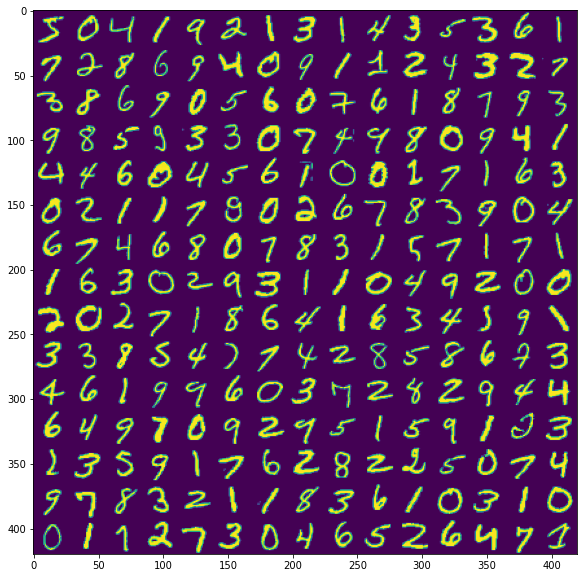

In [ ]:
# Display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# We will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)
k=0
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        #x_decoded = decoder.predict(z_sample)
        digit = x_train[k].reshape(digit_size, digit_size)
        k = k +1
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()


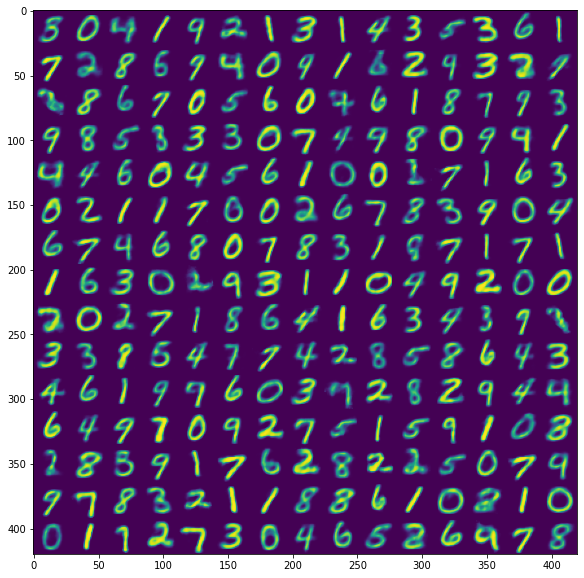

In [ ]:
# Display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# We will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)
k=0
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        #x_decoded = decoder.predict(z_sample)
        digit = x_decoded[k].reshape(digit_size, digit_size)
        k = k +1
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()

